This notebook provides some examples of how to process high-resolution videos of a mouse face using DeepLabCut output.

Author: Oliver Barnstedt

## Import libraries and data

In [1]:
%matplotlib inline
# imports
import pandas as pd
try:
    import pandas_bokeh
except:
    !pip install pandas-bokeh
    import pandas_bokeh
pandas_bokeh.output_notebook()
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from tqdm import tqdm
import math
try:
    import flow_vis  # visualisation from https://github.com/tomrunia/OpticalFlow_Visualization
except:
    !pip install flow_vis
    import flow_vis
from scipy.stats import zscore
from scipy import optimize


Loading BokehJS ...

In [10]:
# define sample range (first and last frames)
sample_frames = (193100, 194100)
sample_size = sample_frames[1] - sample_frames[0]

In [3]:
# define file paths and load DLC file (will not load behaviour MP4 into memory!)
facevidpath = '/Users/Oliver/Google Drive/Imaging_Results/171_172_173_174/Basler acA780-75gm (22611477)_20190220_105916470.mp4'
dlc_facepath = '/Users/Oliver/Google Drive/Imaging_Results/171_172_173_174/Basler acA780-75gm (22611477)_20190220_105916470DeepCut_resnet50_MouseFaceAug21shuffle1_1030000.h5'
dlc_face = pd.read_hdf(dlc_facepath, mode='r').loc[sample_frames[0]:sample_frames[1]]
dlc_face.columns = dlc_face.columns.droplevel()

## Inspect data

In [4]:
# play video with OpenCV in new window (STOP WITH 'Q')
cap = cv2.VideoCapture(facevidpath)
cap.set(1,sample_frames[0])
i=0
while(cap.isOpened()):
    ret, frame = cap.read()
    frame_width  = int(cap.get(3))   # float `width`
    frame_height = int(cap.get(4))  # float `height
    fps = 1/cap.get(2)
    if ret == True:
        frame = cv2.putText(frame, str(i+sample_frames[0]), org=(50,50), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 0, 0), thickness=2)
        cv2.imshow('frame',frame)
        i+=1
    else:
        break
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

In [5]:
# show DLC dataframe
dlc_face

bodyparts   nosetip                           forehead                       \
coords            x           y likelihood           x         y likelihood   
193100     3.445115  325.458780   0.999765  324.062643  2.291651   0.992944   
193101     3.400891  325.506873   0.999725  324.480585  2.310668   0.992658   
193102     3.382392  325.709233   0.999743  324.448754  2.299444   0.992445   
193103     3.409087  325.662172   0.999728  324.392059  2.308221   0.992690   
193104     3.340101  324.997563   0.999814  324.822777  2.108054   0.988725   
...             ...         ...        ...         ...       ...        ...   
194096     7.245467  347.848804   0.999956  331.422334  2.643675   0.799069   
194097     5.685754  350.762805   0.999964  328.823561  3.659981   0.964708   
194098     4.535215  351.162278   0.997791  326.043929  3.515307   0.993018   
194099     4.206095  343.009035   0.999621  325.967346  2.898636   0.987767   
194100     5.465538  347.317348   0.999852  327.131269  3.826529   0.976874   

bodyparts    mouthtip                               chin  ...     pupil3  \
coords              x           y likelihood           x  ... likelihood   
193100     237.618926  500.896323   0.997366  717.505114  ...        1.0   
193101     235.766241  500.577411   0.996961  717.326666  ...        1.0   
193102     236.298322  500.717964   0.995758  717.499695  ...        1.0   
193103     235.704751  500.582834   0.994726  718.220210  ...        1.0   
193104     238.208200  500.488914   0.998632  722.168546  ...        1.0   
...               ...         ...        ...         ...  ...        ...   
194096     303.602051  520.743905   0.335413  546.982700  ...        1.0   
194097     261.800839  510.385798   0.999831  589.382622  ...        1.0   
194098     258.583270  503.724851   0.999994  695.031741  ...        1.0   
194099     252.587585  501.193695   0.989582  688.686942  ...        1.0   
194100     294.660715  519.851826   0.316512  675.351153  ...        1.0   

bodyparts      pupil4                             pupil5              \
coords              x           y likelihood           x           y   
193100     561.792288  155.350320        1.0  547.790438  169.133162   
193101     561.754291  155.458314        1.0  547.667621  169.288778   
193102     561.810827  155.170842        1.0  547.643470  169.161742   
193103     561.812557  155.146246        1.0  547.652950  169.123539   
193104     561.755965  155.500279        1.0  547.583742  170.638284   
...               ...         ...        ...         ...         ...   
194096     577.372035  158.645887        1.0  557.001437  187.921057   
194097     577.133734  158.627645        1.0  557.054027  187.830521   
194098     576.310416  159.837325        1.0  556.612209  188.181137   
194099     576.066267  159.294602        1.0  556.251884  187.991233   
194100     576.151214  157.056947        1.0  555.180427  186.699643   

bodyparts                 pupil6                         
coords    likelihood           x           y likelihood  
193100           1.0  528.802055  167.062678        1.0  
193101           1.0  528.768189  167.076940        1.0  
193102           1.0  528.700348  166.951576        1.0  
193103           1.0  528.703068  166.927484        1.0  
193104           1.0  528.009041  167.021214        1.0  
...              ...         ...         ...        ...  
194096           1.0  517.866673  185.952067        1.0  
194097           1.0  517.926271  185.524608        1.0  
194098           1.0  518.686854  185.830747        1.0  
194099           1.0  518.406206  184.534612        1.0  
194100           1.0  518.270253  183.587308        1.0  

[1001 rows x 39 columns]

In [40]:
# play video with OpenCV with DLC points added, in new window (STOP WITH 'Q')
cap = cv2.VideoCapture(facevidpath)
cap.set(1,sample_frames[0])
i=sample_frames[0]
while(cap.isOpened()):
    facetime = dlc_face.loc[i]
    ret, frame = cap.read()
    if ret == True:
        # add DLC markers:
        for j, marker in enumerate(facetime.index.get_level_values(level=0).unique().tolist()):
            image = cv2.circle(frame, (int(facetime[marker].x), int(facetime[marker].y)), radius=10, 
                               color=[k*255 for k in cm.jet(round(255/12*j))[:3]], thickness=-1)
        image = cv2.putText(image, str(i), org=(50,50), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 0, 0), thickness=2)
        cv2.imshow('frame',image)
    else:
        break
    if (cv2.waitKey(1) & 0xFF == ord('q')) | (i>sample_frames[1]-2):
        break
    i+=1
# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

## Estimate pupil diameter

In [7]:
# clean up DLC data by thresholding likelihood:
like_thresh = 0.9  # likelihood threshold points need to pass
dlc_face_clean = dlc_face.copy()
dlc_face_clean.loc(axis=1)[:, ["x", "y"]] = (np.tile([dlc_face_clean.loc(axis=1)[:, "likelihood"].to_numpy()], 2)[0] > like_thresh) * dlc_face_clean.loc(axis=1)[:, ["x", "y"]]
dlc_face_clean[dlc_face_clean==0] = np.nan  # set markers with low likelihood to NaN
dlc_face_clean = dlc_face_clean.interpolate()  # interpolate linearly across NaNs
dlc_face_clean = dlc_face_clean.fillna(method='bfill').fillna(method='ffill')  # back- and forward-fill NaNs at end and beginning
dlc_face_clean

bodyparts   nosetip                           forehead                       \
coords            x           y likelihood           x         y likelihood   
193100     3.445115  325.458780   0.999765  324.062643  2.291651   0.992944   
193101     3.400891  325.506873   0.999725  324.480585  2.310668   0.992658   
193102     3.382392  325.709233   0.999743  324.448754  2.299444   0.992445   
193103     3.409087  325.662172   0.999728  324.392059  2.308221   0.992690   
193104     3.340101  324.997563   0.999814  324.822777  2.108054   0.988725   
...             ...         ...        ...         ...       ...        ...   
194096     7.245467  347.848804   0.999956  329.726311  3.215455   0.799069   
194097     5.685754  350.762805   0.999964  328.823561  3.659981   0.964708   
194098     4.535215  351.162278   0.997791  326.043929  3.515307   0.993018   
194099     4.206095  343.009035   0.999621  325.967346  2.898636   0.987767   
194100     5.465538  347.317348   0.999852  327.131269  3.826529   0.976874   

bodyparts    mouthtip                               chin  ...     pupil3  \
coords              x           y likelihood           x  ... likelihood   
193100     237.618926  500.896323   0.997366  568.936789  ...        1.0   
193101     235.766241  500.577411   0.996961  568.936789  ...        1.0   
193102     236.298322  500.717964   0.995758  568.936789  ...        1.0   
193103     235.704751  500.582834   0.994726  568.936789  ...        1.0   
193104     238.208200  500.488914   0.998632  568.936789  ...        1.0   
...               ...         ...        ...         ...  ...        ...   
194096     269.161797  509.635186   0.335413  546.982700  ...        1.0   
194097     261.800839  510.385798   0.999831  594.217447  ...        1.0   
194098     258.583270  503.724851   0.999994  641.452195  ...        1.0   
194099     252.587585  501.193695   0.989582  688.686942  ...        1.0   
194100     252.587585  501.193695   0.316512  688.686942  ...        1.0   

bodyparts      pupil4                             pupil5              \
coords              x           y likelihood           x           y   
193100     561.792288  155.350320        1.0  547.790438  169.133162   
193101     561.754291  155.458314        1.0  547.667621  169.288778   
193102     561.810827  155.170842        1.0  547.643470  169.161742   
193103     561.812557  155.146246        1.0  547.652950  169.123539   
193104     561.755965  155.500279        1.0  547.583742  170.638284   
...               ...         ...        ...         ...         ...   
194096     577.372035  158.645887        1.0  557.001437  187.921057   
194097     577.133734  158.627645        1.0  557.054027  187.830521   
194098     576.310416  159.837325        1.0  556.612209  188.181137   
194099     576.066267  159.294602        1.0  556.251884  187.991233   
194100     576.151214  157.056947        1.0  555.180427  186.699643   

bodyparts                 pupil6                         
coords    likelihood           x           y likelihood  
193100           1.0  528.802055  167.062678        1.0  
193101           1.0  528.768189  167.076940        1.0  
193102           1.0  528.700348  166.951576        1.0  
193103           1.0  528.703068  166.927484        1.0  
193104           1.0  528.009041  167.021214        1.0  
...              ...         ...         ...        ...  
194096           1.0  517.866673  185.952067        1.0  
194097           1.0  517.926271  185.524608        1.0  
194098           1.0  518.686854  185.830747        1.0  
194099           1.0  518.406206  184.534612        1.0  
194100           1.0  518.270253  183.587308        1.0  

[1001 rows x 39 columns]

In [41]:
# determine pupil diameter and plot with OpenCV
cap = cv2.VideoCapture(facevidpath)
cap.set(1,sample_frames[0])
i=sample_frames[0]
while(cap.isOpened()):
    facetime = dlc_face_clean.loc[i]
    ret, frame = cap.read()
    if ret == True:
        # determine pupil and plot:
        pupilpoints = np.float32(facetime.loc[['pupil1', 'pupil2', 'pupil3', 'pupil4', 'pupil5', 'pupil6'], ['x', 'y']].values.reshape(6,2))
        pupil_circle = np.asarray(cv2.minEnclosingCircle(pupilpoints), dtype='object')
        image = cv2.circle(frame, [int(k) for k in pupil_circle[0]], radius=int(pupil_circle[1]), color=[255, 255, 255], thickness=2)
        # add DLC markers:
        for j, marker in enumerate(facetime.index.get_level_values(level=0).unique().tolist()):
            image = cv2.circle(frame, (int(facetime[marker].x), int(facetime[marker].y)), radius=5, 
                               color=[k*255 for k in cm.jet(round(255/12*j))[:3]], thickness=-1)
        image = cv2.putText(image, str(i), org=(50,50), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 0, 0), thickness=2)
        cv2.imshow('frame',image)
    else:
        break
    if (cv2.waitKey(1) & 0xFF == ord('q')) | (i>sample_frames[1]-2):
        break
    i+=1
# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

In [11]:
# extract pupil diameter
pupil_diam = pd.Series(index=range(sample_size), dtype='object')
for i in tqdm(range(sample_size)):
    facetime = dlc_face_clean.iloc[i]
    pupilpoints = np.float32(facetime.loc[['pupil1', 'pupil2', 'pupil3', 'pupil4', 'pupil5', 'pupil6'], ['x', 'y']].values.reshape(6,2))
    pupil_circle = np.asarray(cv2.minEnclosingCircle(pupilpoints), dtype='object')
    pupil_diam.loc[i] = pupil_circle[1]

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 509.22it/s]


In [13]:
# Hanning filter
def smooth(x, window_len=11, window='hanning'):
    s = np.r_[x[window_len-1:0:-1], x, x[-2:-window_len-1:-1]]
    w = eval('np.'+window+'(window_len)')
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y

# smoothen signal
smooth_window = 75
pupil_diam_smooth = pd.Series(smooth(pupil_diam, window_len=smooth_window)).shift(periods=-int(smooth_window / 2))[:sample_size].astype(float)

# plot raw and smoothed pupil diameter
pupil_diam_df = pd.DataFrame({'raw': pupil_diam, 'filtered': pupil_diam_smooth})
pupil_diam_df.astype(float).plot_bokeh(xlabel='Frame', ylabel='Pupil diametre [au]')

Figure(id='1152', ...)

## Estimate face regions

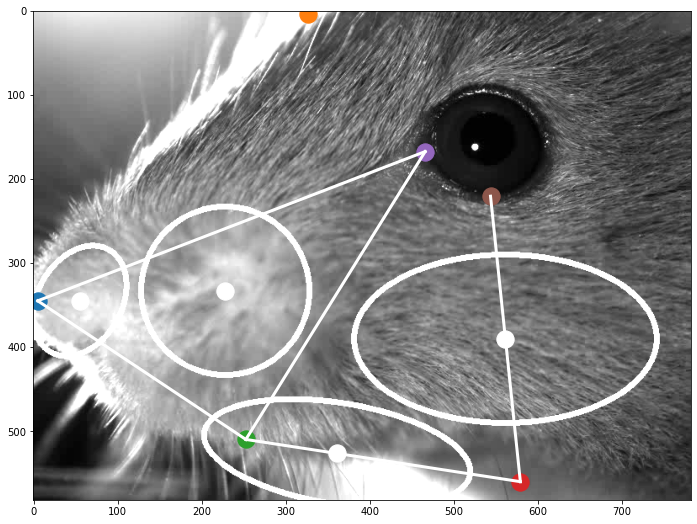

In [14]:
# find face regions based on median locations
face_anchor = dlc_face_clean.loc(axis=1)[['nosetip', 'forehead', 'mouthtip', 'chin', 'tearduct', 'eyelid2'], ['x', 'y']].median()
whiskercentre = np.array(cv2.minEnclosingCircle(np.array(np.vstack([face_anchor.nosetip, face_anchor.mouthtip, face_anchor.tearduct]), dtype=np.float32))[0])
whiskercentre = tuple(np.round(whiskercentre).astype(int) + [-10, 70])
nosecentre = tuple(np.round(face_anchor.nosetip).astype(int) + [50, 0])
mouthcentre = tuple(np.round(face_anchor.mouthtip + (face_anchor.chin - face_anchor.mouthtip)/3).astype(int))
mouthangle = math.degrees(math.atan2((face_anchor.chin[1] - face_anchor.mouthtip[1]), (face_anchor.chin[0] - face_anchor.mouthtip[0])))
cheek_centre = tuple(np.round(face_anchor.eyelid2 + (face_anchor.chin - face_anchor.eyelid2)/2).astype(int))

# plot median points
cap = cv2.VideoCapture(facevidpath)
firstframe = np.array(cap.read()[1][:, :, 0], dtype = np.uint8)
fig, ax = plt.subplots(figsize=(12, 9))
for anchor in face_anchor.index.get_level_values(0).unique().tolist():
    ax.scatter(face_anchor[anchor]['x'], face_anchor[anchor]['y'], s=300)
    
# plot whisker pad
ax.plot([face_anchor.nosetip[0], face_anchor.tearduct[0]], [face_anchor.nosetip[1], face_anchor.tearduct[1]], color='w', lw=3)
ax.plot([face_anchor.nosetip[0], face_anchor.mouthtip[0]], [face_anchor.nosetip[1], face_anchor.mouthtip[1]], color='w', lw=3)
ax.plot([face_anchor.mouthtip[0], face_anchor.tearduct[0]], [face_anchor.mouthtip[1], face_anchor.tearduct[1]], color='w', lw=3)
ax.scatter(whiskercentre[0], whiskercentre[1], s=300, c='w')
whiskers = cv2.circle(firstframe, whiskercentre, 100, color=(255, 0, 0), thickness=5)

# plot nose region
ax.scatter(nosecentre[0], nosecentre[1], s=300, c='w')
nose = cv2.ellipse(firstframe, nosecentre, (70, 50), -60.0, 0.0, 360.0, (255, 0, 0), 5)

# plot mouth region
ax.plot([face_anchor.mouthtip[0], face_anchor.chin[0]], [face_anchor.mouthtip[1], face_anchor.chin[1]], color='w', lw=3)
ax.scatter(mouthcentre[0], mouthcentre[1], s=300, c='w')
mouth = cv2.ellipse(firstframe, mouthcentre, (160, 60), mouthangle, 0.0, 360.0, (255, 0, 0), 5)

# plot cheek region
ax.plot([face_anchor.eyelid2[0], face_anchor.chin[0]], [face_anchor.eyelid2[1], face_anchor.chin[1]], color='w', lw=3)
ax.scatter(cheek_centre[0], cheek_centre[1], s=300, c='w')
cheek = cv2.ellipse(firstframe, cheek_centre, (180, 100), 0.0, 0.0, 360.0, (255, 0, 0), 5)

ax.imshow(firstframe, cmap='gray')


## Calculate motion energy within face regions

In [43]:
# show motion energy with OpenCV in new window (STOP WITH 'Q')
cap = cv2.VideoCapture(facevidpath)
cap.set(1,sample_frames[0])
ret, current_frame = cap.read()
previous_frame = current_frame
i=sample_frames[0]
while(cap.isOpened()):
    if ret == True:
        current_frame_gray = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)
        previous_frame_gray = cv2.cvtColor(previous_frame, cv2.COLOR_BGR2GRAY)
        frame_diff = cv2.applyColorMap(cv2.absdiff(current_frame_gray, previous_frame_gray), cv2.COLORMAP_VIRIDIS)
        whiskers = cv2.circle(frame_diff, whiskercentre, 100, color=(255, 0, 0), thickness=2)
        nose = cv2.ellipse(frame_diff, nosecentre, (70, 50), -60.0, 0.0, 360.0, (255, 0, 0), 2)
        mouth = cv2.ellipse(frame_diff, mouthcentre, (160, 60), mouthangle, 0.0, 360.0, (255, 0, 0), 2)
        cheek = cv2.ellipse(frame_diff, cheek_centre, (180, 100), 0.0, 0.0, 360.0, (255, 0, 0), 2)
        frame_diff = cv2.putText(frame_diff, str(i), org=(50,50), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 0, 0), thickness=2)
        cv2.imshow('frame', frame_diff)
        previous_frame = current_frame.copy()
        ret, current_frame = cap.read()
        i+=1
    else:
        break
    if (i>sample_frames[1]-2):  # at end of samples, loop from beginning
        i=sample_frames[0]
        cap.set(1,sample_frames[0])
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

In [16]:
# define face region masks
canvas = np.zeros([frame_height, frame_width])
whiskermask = cv2.circle(canvas.copy(), whiskercentre, 100, color=(1, 0, 0), thickness=-1).astype(bool)
nosemask = cv2.ellipse(canvas.copy(), nosecentre, (70, 50), -60.0, 0.0, 360.0, (1, 0, 0), -1).astype(bool)
mouthmask = cv2.ellipse(canvas.copy(), mouthcentre, (160, 60), mouthangle, 0.0, 360.0, (1, 0, 0), -1).astype(bool)
cheekmask = cv2.ellipse(canvas.copy(), cheek_centre, (180, 100), 0.0, 0.0, 360.0, (1, 0, 0), -1).astype(bool)
masks = np.array([nosemask, whiskermask, mouthmask, cheekmask]).astype('float32')
masks[masks==0] = np.nan

In [17]:
# calculate motion energy
mask_me = np.empty((sample_size, masks.shape[0]))
cap = cv2.VideoCapture(facevidpath)
cap.set(1,sample_frames[0])
ret, current_frame = cap.read()
previous_frame = current_frame
i=0
with tqdm(total=sample_size) as pbar:
    while(cap.isOpened()):
        if ret == True:
            current_frame_gray = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)
            previous_frame_gray = cv2.cvtColor(previous_frame, cv2.COLOR_BGR2GRAY)
            frame_diff = cv2.absdiff(current_frame_gray, previous_frame_gray)
            for j, mask in enumerate(masks):
                mask_me[i, j] = np.nanmean(frame_diff * mask)
            pbar.update(1)
            previous_frame = current_frame.copy()
            ret, current_frame = cap.read()
            i+=1
        else:
            break
        if i>sample_size-2:
            break
# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

100%|██████████████████████████████████████▉| 999/1000 [00:06<00:00, 159.91it/s]


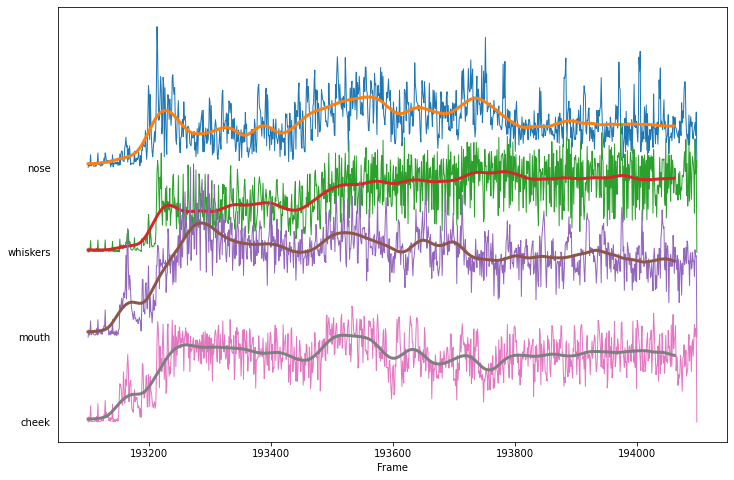

In [18]:
# plot raw and filtered motion energy
fig, ax = plt.subplots(figsize=(12, 8))
motion_energy = pd.DataFrame(data=mask_me, columns=['nose', 'whiskers', 'mouth', 'cheek'], index=range(sample_frames[0], sample_frames[1]))
for i, face_region in enumerate(motion_energy.columns):
    ax.plot(motion_energy[face_region]-i*15, lw=1)
    ax.plot(pd.Series(smooth(motion_energy[face_region]-i*15, window_len=75)[:sample_size], index=range(sample_frames[0], sample_frames[1])).shift(periods=-int(75/2)), lw=3)
    ax.set_xlabel('Frame')
    ax.set(ylabel=None)  # remove the y-axis label
    ax.tick_params(left=False)  # remove the ticks
    ax.set_yticks([0, -15, -30, -45])
    ax.set(yticklabels=motion_energy.columns)  

## Calculate optical flow

In [19]:
# focus on subset of frames because processing is slower (on CPU)
flow_sample_frames = (193470, 193670)

In [44]:
# show optical flow with OpenCV in new window (STOP WITH 'Q')
# see also https://www.geeksforgeeks.org/python-opencv-dense-optical-flow/
use_flow_vis = True  # whether to use flow_vis package to visualise optical flow
blend_gray_optflow = 0.2  # factor for blending in gray frame with optical flow color output video
cap = cv2.VideoCapture(facevidpath)
cap.set(1,flow_sample_frames[0])
ret, current_frame = cap.read()
previous_frame = current_frame
mask = np.zeros_like(current_frame)
mask[..., 1] = 255
i=flow_sample_frames[0]
while(cap.isOpened()):
    if ret == True:
        current_frame_gray = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)
        previous_frame_gray = cv2.cvtColor(previous_frame, cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(previous_frame_gray, current_frame_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        if use_flow_vis:
            rgb = flow_vis.flow_to_color(flow, convert_to_bgr=True)
        else:
            magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
            mask[..., 0] = angle * 180 / np.pi / 2
            mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
            rgb = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)
        if blend_gray_optflow:  # blend in gray frame
            rgb = cv2.addWeighted(current_frame, blend_gray_optflow, rgb, 1-blend_gray_optflow, 0)
        whiskers = cv2.circle(rgb, whiskercentre, 100, color=(255, 0, 0), thickness=2)
        nose = cv2.ellipse(rgb, nosecentre, (70, 50), -60.0, 0.0, 360.0, (255, 0, 0), 2)
        mouth = cv2.ellipse(rgb, mouthcentre, (160, 60), mouthangle, 0.0, 360.0, (255, 0, 0), 2)
        cheek = cv2.ellipse(rgb, cheek_centre, (180, 100), 0.0, 0.0, 360.0, (255, 0, 0), 2)
        rgb = cv2.putText(rgb, str(i), org=(50,50), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 0, 0), thickness=2)
        cv2.imshow("dense optical flow", rgb)
        previous_frame = current_frame.copy()
        ret, current_frame = cap.read()
        i+=1
    else:
        break
    if (i>flow_sample_frames[1]-2):  # at end of samples, loop from beginning
        i=flow_sample_frames[0]
        cap.set(1,flow_sample_frames[0])
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

In [21]:
# calculate average optical flow magnitude/angle per face region, this is slow on CPU!
flow_sample_size = flow_sample_frames[1] - flow_sample_frames[0]  # because this takes longer, take a smaller sample
mask_flow_mag = np.empty((flow_sample_size, masks.shape[0]))
mask_flow_ang = np.empty((flow_sample_size, masks.shape[0]))
cap = cv2.VideoCapture(facevidpath)
cap.set(1,flow_sample_frames[0])
ret, current_frame = cap.read()
previous_frame = current_frame
i=0
with tqdm(total=flow_sample_size) as pbar:
    while(cap.isOpened()):
        if ret == True:
            current_frame_gray = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)
            previous_frame_gray = cv2.cvtColor(previous_frame, cv2.COLOR_BGR2GRAY)
            flow = cv2.calcOpticalFlowFarneback(previous_frame_gray, current_frame_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
            magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
            for j, mask in enumerate(masks):
                mask_flow_mag[i, j] = np.nanmean(magnitude * mask)
                mask_flow_ang[i, j] = np.nanmean(angle * mask)
            pbar.update(1)
            previous_frame = current_frame.copy()
            ret, current_frame = cap.read()
            i+=1
        else:
            break
        if i>flow_sample_size-2:
            break
# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

100%|████████████████████████████████████████▊| 199/200 [00:24<00:00,  8.27it/s]


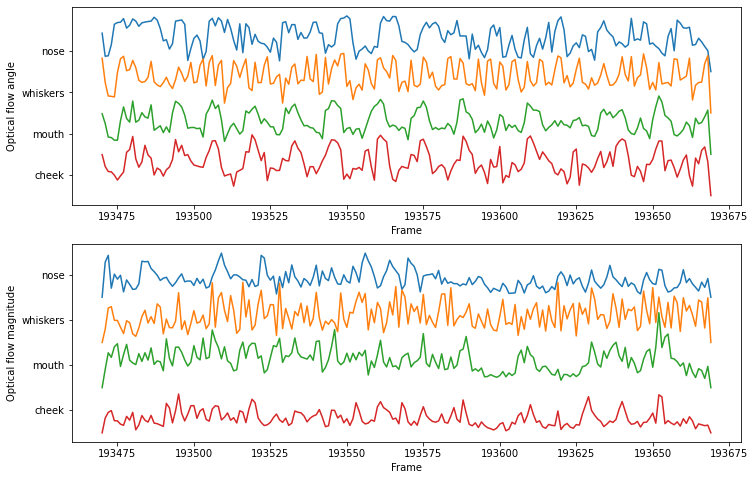

In [22]:
# plot optical flow
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
ang = pd.DataFrame(data=mask_flow_ang, columns=['nose', 'whiskers', 'mouth', 'cheek'], index=range(flow_sample_frames[0], flow_sample_frames[1]))
mag = pd.DataFrame(data=mask_flow_mag, columns=['nose', 'whiskers', 'mouth', 'cheek'], index=range(flow_sample_frames[0], flow_sample_frames[1]))
for i, face_region in enumerate(ang.columns):
    ax[0].plot(ang[face_region]-i*4)
    ax[0].set_xlabel('Frame')
    ax[0].set_ylabel('Optical flow angle')
    ax[0].set_yticks([2, -2, -6, -10])
    ax[0].set(yticklabels=ang.columns)  
    
    ax[1].plot(mag[face_region]-i*8)
    ax[1].set_xlabel('Frame')
    ax[1].set_ylabel('Optical flow magnitude')
    ax[1].set_yticks([4, -4, -12, -20])
    ax[1].set(yticklabels=mag.columns)  

In [24]:
ang.whiskers.plot_bokeh()

Figure(id='1453', ...)

In [25]:
# sine fitting written by unsym: https://stackoverflow.com/a/42322656
def fit_sin(yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = np.array(range(len(yy)))
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1] - tt[0]))  # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:]) + 1])  # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2. ** 0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2. * np.pi * guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):
        return A * np.sin(w * t + p) + c

    try:
        popt, pcov = optimize.curve_fit(sinfunc, tt, yy, p0=guess)
        A, w, p, c = popt
        f = w / (2. * np.pi)
        fitfunc = lambda t: A * np.sin(w * t + p) + c
        return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1. / f, "fitfunc": fitfunc,
                "maxcov": np.max(pcov), "rawres": (guess, popt, pcov)}
    except:
        return np.nan

def fit_sin_w(yy):  # omega
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = np.array(range(len(yy)))
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1] - tt[0]))  # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:]) + 1])  # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2. ** 0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2. * np.pi * guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):
        return A * np.sin(w * t + p) + c
    try:
        popt, pcov = optimize.curve_fit(sinfunc, tt, yy, p0=guess)
        A, w, p, c = popt
        return w
    except:
        return np.nan

def fit_sin_error(yy):  # mean SD error
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = np.array(range(len(yy)))
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1] - tt[0]))  # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:]) + 1])  # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2. ** 0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2. * np.pi * guess_freq, 0., guess_offset])
    def sinfunc(t, A, w, p, c):
        return A * np.sin(w * t + p) + c
    try:
        popt, pcov = optimize.curve_fit(sinfunc, tt, yy, p0=guess)
        A, w, p, c = popt
        return np.mean(np.sqrt(np.diag(pcov)))
    except:
        return np.nan

In [26]:
# fit sine and extract frequency
def freq_analysis(x, fps=75, rollwin=50, min_periods=30, conf=0.5):
    xz = pd.Series(zscore(x.values))
    print('Fitting sine...')
    w = xz.rolling(int(rollwin), center=True, min_periods=min_periods).apply(fit_sin_w)
    error = xz.rolling(int(rollwin), center=True, min_periods=min_periods).apply(fit_sin_error)
    w_clean = w.copy()
    w_clean[w_clean.diff().abs()>(.75/fps)] = np.nan
    w_clean[error>(fps/100)] = np.nan
    w_clean[w_clean<0] = np.nan
    w_clean = w_clean.interpolate(method='polynomial', order=3, limit=int(fps*2))
    w_smooth = w_clean.rolling(int(rollwin/3), center=True, min_periods=int(min_periods/3)).mean(window='gaussian')
    f_smooth = w_smooth/(2.*np.pi)*fps
    return f_smooth

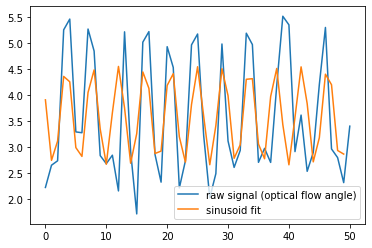

In [27]:
# Illustrate sinusoid fit on a patch of whisking optical flow angle
res = fit_sin(ang.whiskers.loc[193580:193630])
plt.plot(ang.whiskers.loc[193580:193630].values, label='raw signal (optical flow angle)')
plt.plot(res['fitfunc'](range(50)), label='sinusoid fit')
plt.legend()

In [29]:
# Apply sine fit to all optical flow angle data
face_freq = ang.apply(freq_analysis)

Fitting sine...
Fitting sine...
Fitting sine...
Fitting sine...


In [30]:
face_freq.index = pd.Index(range(flow_sample_frames[0], flow_sample_frames[1]))
face_freq.plot_bokeh(ylabel='Frequency [Hz]', xlabel='Frame')

Figure(id='1603', ...)